In [ ]:
!pip install -U imbalanced-learn
!pip install spacy
!python -m spacy download en_core_web_sm

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import re

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import string

import spacy
from tqdm.auto import tqdm
import time

In [84]:
data = pd.read_csv("all_reviews4.csv", sep=";", on_bad_lines="skip")

In [85]:
data.head(10)

,Review,Rating
0,Hollywood Hotel sure lives up to its name. Yo...,5
1,We had a reservation at this hotel this weeken...,5
2,We were mostly happy with our stay here. The s...,4
3,Pil give us great customer service. He took go...,5
4,Very friendly staff. Daniel did an excellent j...,5
5,Daniel made me feel very comfortable and welco...,5
6,"We needed bag storage, early check in, and bag...",5
7,We checked into the holllywood hotel on March ...,1
8,We have stayed at this hotel three times now a...,5
9,The Hollywood Hotel is the place to stay when ...,5


In [86]:
data.tail()

,Review,Rating
35573,We selected this hotel for its close proximity...,5
35574,"Good facilities, modern and beautiful rooms, a...",4
35575,Stayed for 4 days 1St Sept 4th Sept We stayed...,5
35576,"Our room was lovely,we had a brilliant doorman...",5
35577,"Really enjoyed our experience, hotel was clean...",4


# EDA

## Handling Null Values

In [87]:
data.isna().any()

Review    False
Rating    False
dtype: bool

In [88]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [89]:
data.shape

(35578, 2)

## Handling Duplicate Values

In [90]:
data.nunique().any()

True

In [91]:
data.nunique()

Review    34570
Rating        5
dtype: int64

## Preprocessing the Text

In [92]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [93]:
nlp

In [94]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [95]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/35578 [00:00<?, ?it/s]

Wall time: 13min 28s


In [96]:
def preprocess_signs(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r"https?://\s+ www\.\s+", '', text)
    
    #Remove html
    text = re.sub(r"<.*?>", '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

In [97]:
data['Review'] = data['Review'].apply(preprocess_signs)

## Commonly Used Words

In [98]:
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

In [99]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(data['Review'].values)

In [100]:
# Split the text into individual words
words = all_text.split()

In [101]:
# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [102]:
# Count the frequency of each word
word_counts = Counter(words)

In [103]:
top_words = word_counts.most_common(50)
top_words

[('room', 51213),
 ('hotel', 44606),
 ('stay', 28387),
 ('staff', 19019),
 ('great', 18190),
 ('good', 14651),
 ('location', 14392),
 ('clean', 13167),
 ('night', 11663),
 ('nice', 10112),
 ('time', 10047),
 ('walk', 9941),
 ('bed', 9320),
 ('check', 8883),
 ('friendly', 8496),
 ('service', 8472),
 ('small', 8469),
 ('day', 8364),
 ('helpful', 7378),
 ('place', 7268),
 ('bathroom', 7266),
 ('new', 7261),
 ('breakfast', 6472),
 ('need', 6429),
 ('like', 6276),
 ('view', 6248),
 ('comfortable', 5962),
 ('desk', 5869),
 ('floor', 5816),
 ('close', 5762),
 ('universal', 5395),
 ('go', 5320),
 ('park', 5235),
 ('restaurant', 4986),
 ('city', 4872),
 ('get', 4835),
 ('area', 4757),
 ('bar', 4753),
 ('come', 4674),
 ('price', 4530),
 ('book', 4528),
 ('look', 4523),
 ('recommend', 4463),
 ('shower', 4415),
 ('find', 4343),
 ('2', 4334),
 ('empire', 4310),
 ('nyc', 4218),
 ('minute', 4189),
 ('lobby', 4187)]

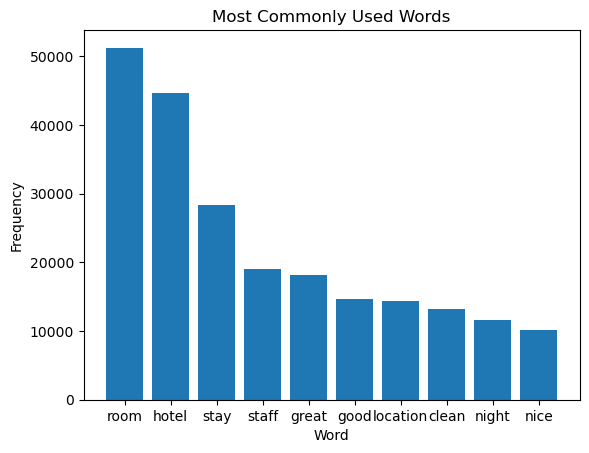

In [104]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

## Converting Text into Numerical Features / Vectorization

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Review'])
y = data['Rating']

## Class Distributions

In [106]:
# Count the number of instances in each class
class_counts = data['Rating'].value_counts()

# Print the class distribution
print('Ratings distribution:')
print(class_counts)

Ratings distribution:
5    15104
4     9581
3     5243
1     2942
2     2708
Name: Rating, dtype: int64


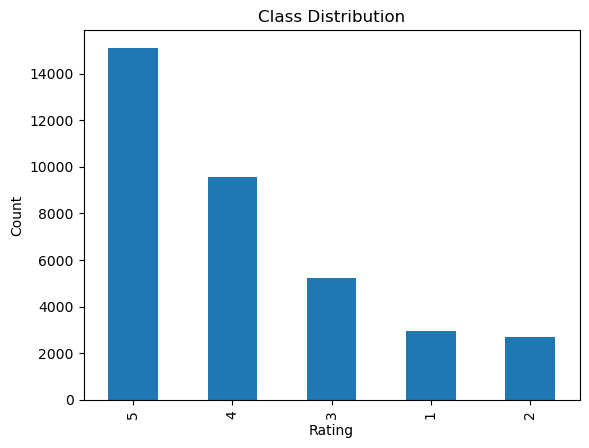

In [107]:
class_counts.plot.bar()
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## ML Models

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
import sklearn
print(sklearn.__version__)

1.0.2


In [111]:
# train a Logistic Regression Model
lrm = LogisticRegression(max_iter=1000)

In [112]:
lrm.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [113]:
# evaluate the classifier on the test set
y_pred = lrm.predict(X_test)

In [30]:
y_pred

array([1, 5, 5, ..., 4, 5, 5], dtype=int64)

In [114]:
acc_logisticregression = accuracy_score(y_test, y_pred)
f1_logisticregression = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc_logisticregression*100, "%")
print("f1score:", f1_logisticregression*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 62.296233839235526 %
f1score: 52.77455213472092 %
[[ 376   63   88   29   31]
 [ 142  108  185   53   29]
 [  64   56  408  368  104]
 [  16   11  192  985  697]
 [   6    5   35  509 2556]]


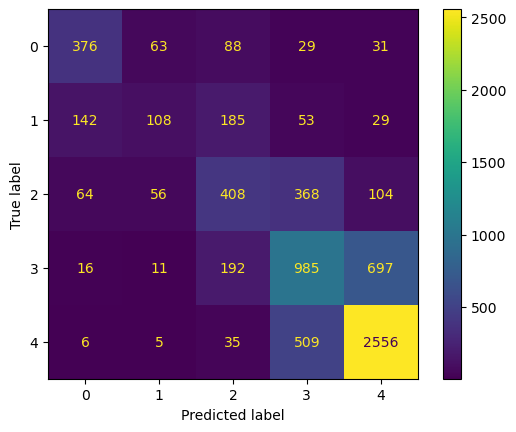

In [115]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## Multinomial Naive Bayes Model

In [116]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
mnb = MultinomialNB()

In [117]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [118]:
# evaluate the classifier on the test set
y_pred = mnb.predict(X_test)
y_pred

array([5, 5, 5, ..., 4, 5, 5], dtype=int64)

In [119]:
acc_naivebayes = accuracy_score(y_test, y_pred)
f1_naivebayes = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc_naivebayes*100, "%")
print("f1score:", f1_naivebayes*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 51.68634064080945 %
f1score: 27.164097184934523 %
[[  71    0  137  204  175]
 [  12    0   81  303  121]
 [   3    0   43  657  297]
 [   1    0    5  672 1223]
 [   0    1    1  217 2892]]


## Decision Tree

In [120]:
from sklearn import tree

In [121]:
dtc = tree.DecisionTreeClassifier()

In [122]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

[Text(0.932532401483884, 0.9965986394557823, 'X[18648] <= 0.033\ngini = 0.708\nsamples = 24272\nvalue = [1847, 1801, 3596, 6564, 10464]'),
 Text(0.8663777741796345, 0.9897959183673469, 'X[10582] <= 0.068\ngini = 0.721\nsamples = 23031\nvalue = [1847, 1800, 3592, 6548, 9244]'),
 Text(0.7700308866273708, 0.9829931972789115, 'X[21726] <= 0.076\ngini = 0.752\nsamples = 17385\nvalue = [1793, 1669, 3069, 4812, 6042]'),
 Text(0.723089774728026, 0.9761904761904762, 'X[7526] <= 0.035\ngini = 0.759\nsamples = 16423\nvalue = [1774, 1638, 3036, 4653, 5322]'),
 Text(0.6539729048720587, 0.9693877551020408, 'X[20106] <= 0.048\ngini = 0.751\nsamples = 15892\nvalue = [1510, 1500, 2945, 4623, 5314]'),
 Text(0.5634868306127012, 0.9625850340136054, 'X[21604] <= 0.025\ngini = 0.739\nsamples = 12515\nvalue = [1258, 1092, 2015, 3457, 4693]'),
 Text(0.5161588737297151, 0.95578231292517, 'X[3505] <= 0.063\ngini = 0.724\nsamples = 11534\nvalue = [952, 898, 1814, 3327, 4543]'),
 Text(0.48566560330409936, 0.94897

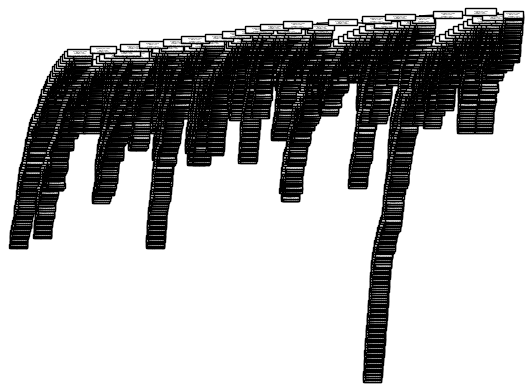

In [64]:
tree.plot_tree(dtc)

In [123]:
# evaluate the classifier on the test set
y_pred = dtc.predict(X_test)

In [40]:
y_pred

array([2, 4, 5, ..., 2, 5, 3], dtype=int64)

In [124]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("f1 score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 49.058459808881395 %
f1 score: 40.13755352800635 %
[[ 242   87   84   83   91]
 [ 100  126  112  108   71]
 [  97  102  264  322  215]
 [  64   99  294  765  679]
 [  66   59  221  671 2094]]


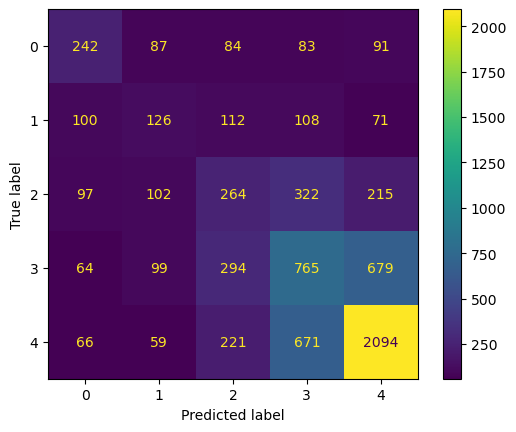

In [125]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
rfc = RandomForestClassifier(random_state=0)

In [128]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [129]:
# evaluate the classifier on the test set
y_pred = rfc.predict(X_test)

In [55]:
y_pred

array([5, 5, 5, ..., 3, 5, 5], dtype=int64)

In [130]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("f1 score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 58.23496346261945 %
f1 score: 43.14657425634522 %
[[ 319    9   83   60  116]
 [ 101   32  130  132  122]
 [  55    6  206  450  283]
 [  12    2   41  755 1091]
 [   7    0   11  261 2832]]


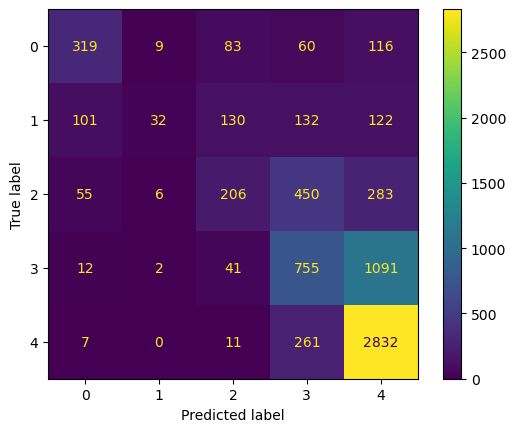

In [131]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()